Constant elasticity of variance model (cev)

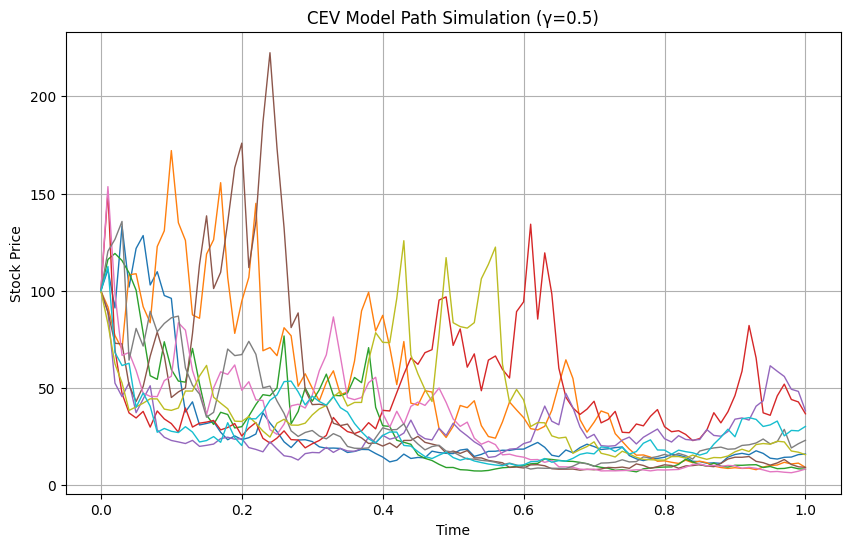

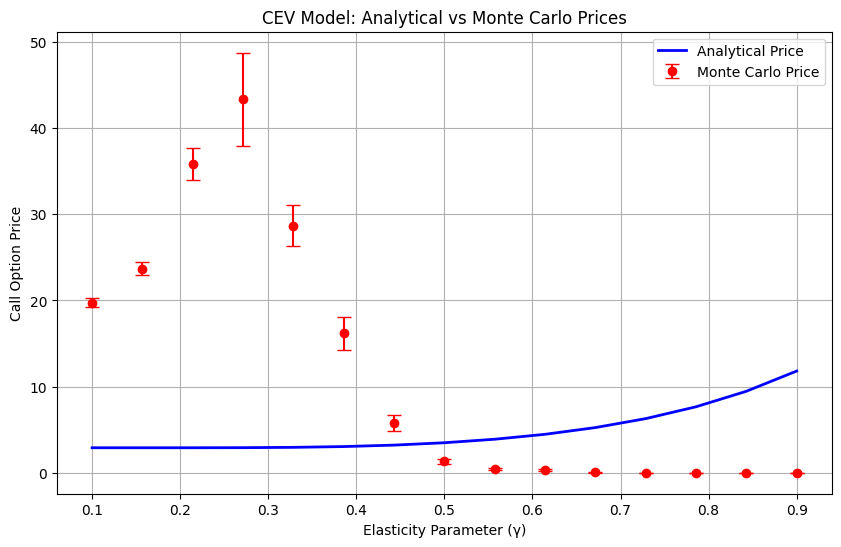

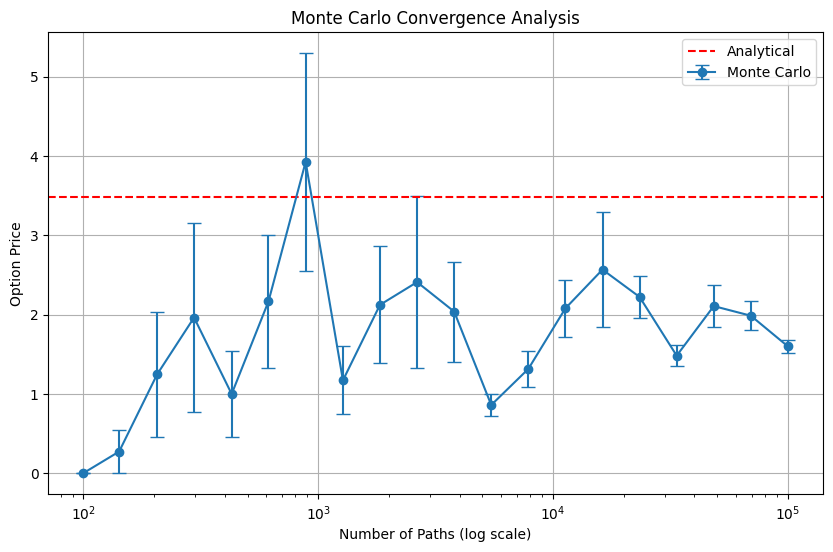

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ncx2

def cev_analytical(S0, K, T, r, q, sigma, gamma, option_type='call'):
    if gamma >= 1:
        raise ValueError("Gamma must be < 1 for this implementation")
    
    beta = gamma
    numerator = (r - q)
    denominator = sigma**2 * (1 - beta) * (np.exp((r - q) * (1 - beta) * T) - 1)
    k = numerator / denominator
    
    phi_S0 = (S0 ** (2 * (1 - beta))) / (sigma**2 * (1 - beta)**2 * k)
    X = (K ** (2 * (1 - beta))) / (sigma**2 * (1 - beta)**2 * k * np.exp((r - q) * (1 - beta) * T))
    
    df1 = 2 + 2 / (1 - beta)
    df2 = 2 / (1 - beta)
    
    term1 = S0 * np.exp(-q * T) * (1 - ncx2.cdf(2 * k * X, df1, 2 * k * phi_S0))
    term2 = K * np.exp(-r * T) * ncx2.cdf(2 * k * phi_S0, df2, 2 * k * X)
    
    call_price = term1 - term2
    
    if option_type == 'call':
        return call_price
    else:
        put_price = call_price - S0 * np.exp(-q * T) + K * np.exp(-r * T)
        return put_price

def cev_monte_carlo(S0, K, T, r, q, sigma, gamma, option_type='call', num_paths=10000, num_steps=100, seed=None):
    np.random.seed(seed)
    num_paths = (num_paths // 2) * 2  # Ensure even number for variance reduction
    dt = T / num_steps
    
    X = np.zeros((num_steps + 1, num_paths))
    X[0] = np.log(S0)
    
    paths = num_paths // 2
    dW = np.random.normal(0, np.sqrt(dt), (num_steps, paths))
    dW = np.concatenate([dW, -dW], axis=1)  # Antithetic variates
    
    for t in range(1, num_steps + 1):
        X_prev = X[t - 1]
        vol = sigma * np.exp(gamma * X_prev)
        X[t] = X_prev + (r - q - 0.5 * vol**2) * dt + vol * dW[t - 1]
    
    S_T = np.exp(X[-1])
    payoff = np.maximum(S_T - K, 0) if option_type == 'call' else np.maximum(K - S_T, 0)
    price = np.exp(-r * T) * np.mean(payoff)
    stderr = np.exp(-r * T) * np.std(payoff) / np.sqrt(num_paths)
    
    return price, stderr

def plot_cev_paths(S0=100, T=1, r=0.05, q=0.02, sigma=0.3, gamma=0.5, num_paths=10, num_steps=100):
    np.random.seed(42)
    t = np.linspace(0, T, num_steps + 1)
    X = np.zeros((num_steps + 1, num_paths))
    X[0] = np.log(S0)
    
    for i in range(1, num_steps + 1):
        dW = np.random.normal(0, np.sqrt(T / num_steps), num_paths)
        vol = sigma * np.exp(gamma * X[i - 1])
        X[i] = X[i - 1] + (r - q - 0.5 * vol**2) * (T / num_steps) + vol * dW
    
    ST = np.exp(X)
    plt.figure(figsize=(10, 6))
    for path in range(num_paths):
        plt.plot(t, ST[:, path], lw=1)
    plt.title(f'CEV Model Path Simulation (γ={gamma})')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.grid(True)
    plt.show()

def plot_price_comparison(S0=100, K=100, T=1, r=0.05, q=0.02, sigma=0.3):
    gamma_values = np.linspace(0.1, 0.9, 15)
    analytical_prices = []
    mc_prices = []
    mc_errors = []
    
    for gamma in gamma_values:
        analytical = cev_analytical(S0, K, T, r, q, sigma, gamma)
        mc, err = cev_monte_carlo(S0, K, T, r, q, sigma, gamma, num_paths=5000)
        analytical_prices.append(analytical)
        mc_prices.append(mc)
        mc_errors.append(err)
    
    plt.figure(figsize=(10, 6))
    plt.plot(gamma_values, analytical_prices, 'b-', lw=2, label='Analytical Price')
    plt.errorbar(gamma_values, mc_prices, yerr=mc_errors, fmt='ro', markersize=6, capsize=5, label='Monte Carlo Price')
    plt.title('CEV Model: Analytical vs Monte Carlo Prices')
    plt.xlabel('Elasticity Parameter (γ)')
    plt.ylabel('Call Option Price')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_convergence(S0=100, K=100, T=1, r=0.05, q=0.02, sigma=0.3, gamma=0.5):
    path_counts = np.logspace(2, 5, num=20, dtype=int)
    path_counts = np.unique([(n//2)*2 for n in path_counts])
    analytical_price = cev_analytical(S0, K, T, r, q, sigma, gamma)
    mc_prices = []
    mc_errors = []
    
    for n in path_counts:
        price, err = cev_monte_carlo(S0, K, T, r, q, sigma, gamma, num_paths=n)
        mc_prices.append(price)
        mc_errors.append(err)
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(path_counts, mc_prices, yerr=mc_errors, fmt='-o', markersize=6, capsize=5, label='Monte Carlo')
    plt.axhline(analytical_price, color='r', linestyle='--', label='Analytical')
    plt.title('Monte Carlo Convergence Analysis')
    plt.xlabel('Number of Paths (log scale)')
    plt.ylabel('Option Price')
    plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    base_params = {'S0': 100, 'T': 1, 'r': 0.05, 'q': 0.02, 'sigma': 0.3}
    plot_cev_paths(**base_params, gamma=0.5)
    plot_price_comparison(**base_params, K=100)
    plot_convergence(**base_params, K=100, gamma=0.5)
